# Customer Churn Prediction Model

## Farm2Home ML Model Training

This notebook trains a machine learning model to predict customer churn risk (likelihood of a customer stopping purchases).

**Features:**
- Recency (days since last purchase)
- Frequency (orders per time period)
- Average gap days between orders
- Total spend
- Spend trend (increasing, decreasing, stable)
- Days since last order
- Category preference

**Output:** 
- `customer_churn_model.pkl` - Trained model
- `churn_scaler.pkl` - Feature scaler
- `churn_label_encoder.pkl` - Categorical encoder

**Goal:** Predict churn risk score (0-1) for each customer to enable proactive re-engagement campaigns.


## 1. Import Libraries


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import warnings
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import os

warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")


✅ Libraries imported successfully


## 2. Load Customer Dataset


In [2]:
# Load data from CSV files or generate synthetic data
print("📚 Loading customer dataset...")

try:
    # Try loading from CSV files
    customer_df = pd.read_csv('../customer_data.csv')
    print("✅ Loaded from CSV file")
except:
    try:
        customer_df = pd.read_csv('customer_data.csv')
        print("✅ Loaded from current directory")
    except Exception as e:
        print(f"⚠️  Could not load CSV files: {e}")
        print("📊 Generating synthetic customer data for training...")
        
        # Generate comprehensive synthetic customer data
        np.random.seed(42)
        n_customers = 3000
        
        # Customer categories
        categories = ['Vegetables', 'Fruits', 'Grains', 'Dairy', 'Spices', 'Pulses', 'Oil', 'Nuts']
        spend_trends = ['increasing', 'decreasing', 'stable']
        
        # Generate customer data
        customer_ids = [f'USER_{i:04d}' for i in range(1, n_customers + 1)]
        
        # Base date (today)
        today = datetime.now()
        
        data = []
        
        for i, customer_id in enumerate(customer_ids):
            # Customer join date (1-365 days ago)
            join_date = today - timedelta(days=np.random.randint(30, 365))
            
            # Total orders (1-50)
            total_orders = np.random.randint(1, 51)
            
            # Last purchase date (varies based on churn probability)
            # Churned customers: 30-180 days ago
            # Active customers: 0-30 days ago
            churn_prob = np.random.random()
            
            if churn_prob > 0.6:  # 40% churned customers
                last_purchase = today - timedelta(days=np.random.randint(30, 180))
                churned = 1
            else:  # 60% active customers
                last_purchase = today - timedelta(days=np.random.randint(0, 30))
                churned = 0
            
            # Days since last order
            days_since_last_order = (today - last_purchase).days
            
            # Average gap between orders (days)
            if total_orders > 1:
                total_days_active = (last_purchase - join_date).days
                avg_gap_days = max(1, total_days_active / total_orders)
            else:
                avg_gap_days = days_since_last_order
            
            # Total spend (higher for active customers)
            if churned == 0:
                total_spend = np.random.uniform(5000, 50000)
            else:
                total_spend = np.random.uniform(1000, 15000)
            
            # Spend trend (churned customers more likely to have decreasing trend)
            if churned == 1:
                trend_weights = [0.1, 0.7, 0.2]  # decreasing most likely
            else:
                trend_weights = [0.4, 0.2, 0.4]  # increasing or stable
            
            spend_trend = np.random.choice(spend_trends, p=trend_weights)
            
            # Category preference
            category_preference = np.random.choice(categories)
            
            data.append({
                'customer_id': customer_id,
                'last_purchase_date': last_purchase.strftime('%Y-%m-%d'),
                'total_orders': total_orders,
                'avg_gap_days': round(avg_gap_days, 2),
                'total_spend': round(total_spend, 2),
                'spend_trend': spend_trend,
                'days_since_last_order': days_since_last_order,
                'category_preference': category_preference,
                'churned': churned
            })
        
        customer_df = pd.DataFrame(data)
        print(f"✅ Generated {len(customer_df)} synthetic customer records")

print(f"\n📊 Dataset Shape: {customer_df.shape}")
print(f"\n📋 First 5 rows:")
print(customer_df.head())


📚 Loading customer dataset...
⚠️  Could not load CSV files: [Errno 2] No such file or directory: 'customer_data.csv'
📊 Generating synthetic customer data for training...
✅ Generated 3000 synthetic customer records

📊 Dataset Shape: (3000, 9)

📋 First 5 rows:
  customer_id last_purchase_date  total_orders  avg_gap_days  total_spend  \
0   USER_0001         2025-10-28            29          4.31     31939.63   
1   USER_0002         2025-10-15            11         20.36     32050.18   
2   USER_0003         2025-08-29             2        135.50      1010.90   
3   USER_0004         2025-10-11            22         14.50     18105.31   
4   USER_0005         2025-10-06            16         11.75     40332.92   

  spend_trend  days_since_last_order category_preference  churned  
0  increasing                      7              Grains        0  
1      stable                     20              Pulses        0  
2      stable                     67          Vegetables        1  
3     

## 3. Data Exploration


In [3]:
print("\n📊 Dataset Info:")
print(customer_df.info())

print("\n📈 Statistical Summary:")
print(customer_df.describe())

print("\n🎯 Churn Distribution:")
print(customer_df['churned'].value_counts())
print(f"\nChurn Rate: {customer_df['churned'].mean() * 100:.2f}%")



📊 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            3000 non-null   object 
 1   last_purchase_date     3000 non-null   object 
 2   total_orders           3000 non-null   int64  
 3   avg_gap_days           3000 non-null   float64
 4   total_spend            3000 non-null   float64
 5   spend_trend            3000 non-null   object 
 6   days_since_last_order  3000 non-null   int64  
 7   category_preference    3000 non-null   object 
 8   churned                3000 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 211.1+ KB
None

📈 Statistical Summary:
       total_orders  avg_gap_days   total_spend  days_since_last_order  \
count   3000.000000   3000.000000   3000.000000            3000.000000   
mean      25.512000     11.596633  20285.216403              50.

## 4. Feature Engineering


In [4]:
print("🔧 Engineering features...")

# Create a copy for feature engineering
df = customer_df.copy()

# Convert last_purchase_date to datetime
df['last_purchase_date'] = pd.to_datetime(df['last_purchase_date'])

# Calculate first purchase date (approximate from join date and total orders)
# Assume first order was avg_gap_days after join
today = datetime.now()
df['first_purchase_date'] = df['last_purchase_date'] - pd.to_timedelta(
    df['total_orders'] * df['avg_gap_days'], unit='D'
)

# Feature 1: Recency (days since last purchase)
df['recency'] = (today - df['last_purchase_date']).dt.days

# Feature 2: Frequency (total orders / total days active)
df['total_days_active'] = (today - df['first_purchase_date']).dt.days
df['total_days_active'] = df['total_days_active'].clip(lower=1)  # Avoid division by zero
df['frequency'] = df['total_orders'] / df['total_days_active']

# Feature 3: Average gap days (already exists, but ensure it's positive)
df['avg_gap_days'] = df['avg_gap_days'].clip(lower=1)

# Feature 4: Total spend (already exists, normalize later)

# Feature 5: Spend trend (encode as numeric)
# increasing = 1, stable = 0, decreasing = -1
df['spend_trend_encoded'] = df['spend_trend'].map({
    'increasing': 1,
    'stable': 0,
    'decreasing': -1
})

# Feature 6: Days since last order (already exists, same as recency)
# We'll use recency instead to avoid duplication

# Feature 7: Category preference (encode later)

# Additional engineered features:
# Average order value
df['avg_order_value'] = df['total_spend'] / df['total_orders'].clip(lower=1)

# Purchase velocity (orders per month)
df['purchase_velocity'] = (df['total_orders'] / df['total_days_active']) * 30

# Recency ratio (recency / avg_gap_days) - how many average gaps since last purchase
df['recency_ratio'] = df['recency'] / df['avg_gap_days'].clip(lower=1)

print("✅ Feature engineering complete")
print(f"\n📊 New features created:")
print(df[['recency', 'frequency', 'avg_gap_days', 'total_spend', 
          'spend_trend_encoded', 'avg_order_value', 'purchase_velocity', 
          'recency_ratio', 'churned']].head())


🔧 Engineering features...
✅ Feature engineering complete

📊 New features created:
   recency  frequency  avg_gap_days  total_spend  spend_trend_encoded  \
0        7   0.219697          4.31     31939.63                    1   
1       20   0.045082         20.36     32050.18                    0   
2       67   0.005917        135.50      1010.90                    0   
3       24   0.064140         14.50     18105.31                    0   
4       29   0.073733         11.75     40332.92                    1   

   avg_order_value  purchase_velocity  recency_ratio  churned  
0      1101.366552           6.590909       1.624130        0  
1      2913.652727           1.352459       0.982318        0  
2       505.450000           0.177515       0.494465        1  
3       822.968636           1.924198       1.655172        0  
4      2520.807500           2.211982       2.468085        0  


In [5]:
print("🧹 Preprocessing data...")

# Select features for model
feature_columns = [
    'recency',
    'frequency',
    'avg_gap_days',
    'total_spend',
    'spend_trend_encoded',
    'days_since_last_order',
    'avg_order_value',
    'purchase_velocity',
    'recency_ratio'
]

# Add category preference (will be encoded)
categorical_features = ['category_preference']

# Prepare feature matrix
X_numeric = df[feature_columns].copy()
X_categorical = df[categorical_features].copy()

# Encode categorical variables
label_encoder = LabelEncoder()
X_categorical_encoded = label_encoder.fit_transform(X_categorical['category_preference'])
X_categorical_encoded = pd.DataFrame(
    X_categorical_encoded, 
    columns=['category_preference_encoded'],
    index=X_numeric.index
)

# Combine numeric and encoded categorical features
X = pd.concat([X_numeric, X_categorical_encoded], axis=1)

# Target variable
y = df['churned'].values

print(f"\n✅ Feature matrix shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")
print(f"\n📋 Feature columns: {list(X.columns)}")
print(f"\n📊 First 5 rows of features:")
print(X.head())


🧹 Preprocessing data...

✅ Feature matrix shape: (3000, 10)
✅ Target shape: (3000,)

📋 Feature columns: ['recency', 'frequency', 'avg_gap_days', 'total_spend', 'spend_trend_encoded', 'days_since_last_order', 'avg_order_value', 'purchase_velocity', 'recency_ratio', 'category_preference_encoded']

📊 First 5 rows of features:
   recency  frequency  avg_gap_days  total_spend  spend_trend_encoded  \
0        7   0.219697          4.31     31939.63                    1   
1       20   0.045082         20.36     32050.18                    0   
2       67   0.005917        135.50      1010.90                    0   
3       24   0.064140         14.50     18105.31                    0   
4       29   0.073733         11.75     40332.92                    1   

   days_since_last_order  avg_order_value  purchase_velocity  recency_ratio  \
0                      7      1101.366552           6.590909       1.624130   
1                     20      2913.652727           1.352459       0.982318   

## 6. Train/Test Split


In [6]:
from sklearn.model_selection import train_test_split

# Split data 80/20
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"📊 Training set: {X_train.shape[0]} samples")
print(f"📊 Test set: {X_test.shape[0]} samples")
print(f"\n🎯 Churn rate - Train: {y_train.mean() * 100:.2f}%, Test: {y_test.mean() * 100:.2f}%")


📊 Training set: 2400 samples
📊 Test set: 600 samples

🎯 Churn rate - Train: 38.71%, Test: 38.67%


## 7. Feature Scaling


In [7]:
# Scale features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Features scaled using StandardScaler")
print(f"📊 Scaled training set shape: {X_train_scaled.shape}")
print(f"📊 Scaled test set shape: {X_test_scaled.shape}")


✅ Features scaled using StandardScaler
📊 Scaled training set shape: (2400, 10)
📊 Scaled test set shape: (600, 10)


## 8. Train Models


In [8]:
print("🤖 Training multiple models...")
print("=" * 80)

models = {}
results = {}

# Model 1: Logistic Regression
print("\n1️⃣ Training Logistic Regression...")
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

models['Logistic Regression'] = lr_model
results['Logistic Regression'] = {
    'accuracy': accuracy_score(y_test, lr_pred),
    'precision': precision_score(y_test, lr_pred),
    'recall': recall_score(y_test, lr_pred),
    'f1': f1_score(y_test, lr_pred),
    'auc': roc_auc_score(y_test, lr_pred_proba)
}

print(f"   ✅ Accuracy: {results['Logistic Regression']['accuracy']:.4f}")
print(f"   ✅ AUC: {results['Logistic Regression']['auc']:.4f}")

# Model 2: Random Forest
print("\n2️⃣ Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)
rf_pred = rf_model.predict(X_test_scaled)
rf_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]

models['Random Forest'] = rf_model
results['Random Forest'] = {
    'accuracy': accuracy_score(y_test, rf_pred),
    'precision': precision_score(y_test, rf_pred),
    'recall': recall_score(y_test, rf_pred),
    'f1': f1_score(y_test, rf_pred),
    'auc': roc_auc_score(y_test, rf_pred_proba)
}

print(f"   ✅ Accuracy: {results['Random Forest']['accuracy']:.4f}")
print(f"   ✅ AUC: {results['Random Forest']['auc']:.4f}")

# Model 3: XGBoost
print("\n3️⃣ Training XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)
xgb_model.fit(X_train_scaled, y_train)
xgb_pred = xgb_model.predict(X_test_scaled)
xgb_pred_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]

models['XGBoost'] = xgb_model
results['XGBoost'] = {
    'accuracy': accuracy_score(y_test, xgb_pred),
    'precision': precision_score(y_test, xgb_pred),
    'recall': recall_score(y_test, xgb_pred),
    'f1': f1_score(y_test, xgb_pred),
    'auc': roc_auc_score(y_test, xgb_pred_proba)
}

print(f"   ✅ Accuracy: {results['XGBoost']['accuracy']:.4f}")
print(f"   ✅ AUC: {results['XGBoost']['auc']:.4f}")

print("\n" + "=" * 80)
print("✅ All models trained successfully!")


🤖 Training multiple models...

1️⃣ Training Logistic Regression...
   ✅ Accuracy: 0.9950
   ✅ AUC: 0.9997

2️⃣ Training Random Forest Classifier...
   ✅ Accuracy: 1.0000
   ✅ AUC: 1.0000

3️⃣ Training XGBoost Classifier...
   ✅ Accuracy: 1.0000
   ✅ AUC: 1.0000

✅ All models trained successfully!


In [9]:
print("\n📊 Model Comparison Summary:")
print("=" * 80)

comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.sort_values('auc', ascending=False)

print("\n" + comparison_df.to_string())

# Select best model based on AUC
selected_model_name = comparison_df.index[0]
selected_model = models[selected_model_name]

print(f"\n🏆 Selected Model: {selected_model_name}")
print(f"   AUC Score: {comparison_df.loc[selected_model_name, 'auc']:.4f}")
print(f"   F1 Score: {comparison_df.loc[selected_model_name, 'f1']:.4f}")

# Save results for later use
model_results = results.copy()



📊 Model Comparison Summary:

                     accuracy  precision    recall        f1       auc
Random Forest           1.000        1.0  1.000000  1.000000  1.000000
XGBoost                 1.000        1.0  1.000000  1.000000  1.000000
Logistic Regression     0.995        1.0  0.987069  0.993492  0.999719

🏆 Selected Model: Random Forest
   AUC Score: 1.0000
   F1 Score: 1.0000


## 10. Detailed Evaluation of Best Model



📈 Detailed Evaluation: Random Forest

📋 Classification Report:
              precision    recall  f1-score   support

      Active       1.00      1.00      1.00       368
     Churned       1.00      1.00      1.00       232

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600


📊 Confusion Matrix:
[[368   0]
 [  0 232]]


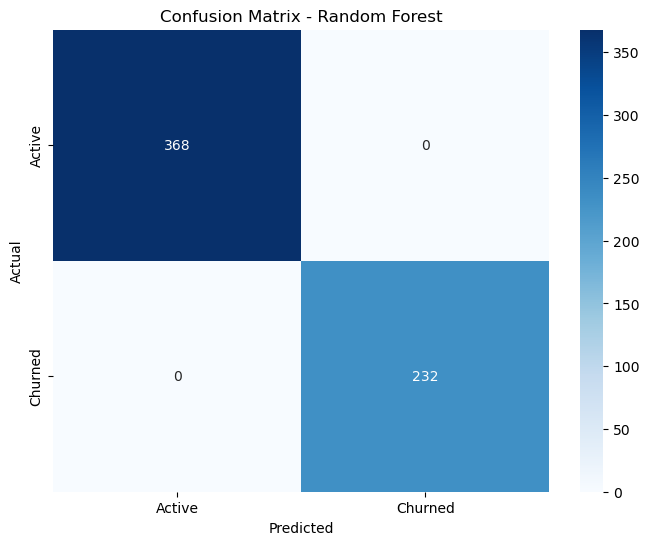

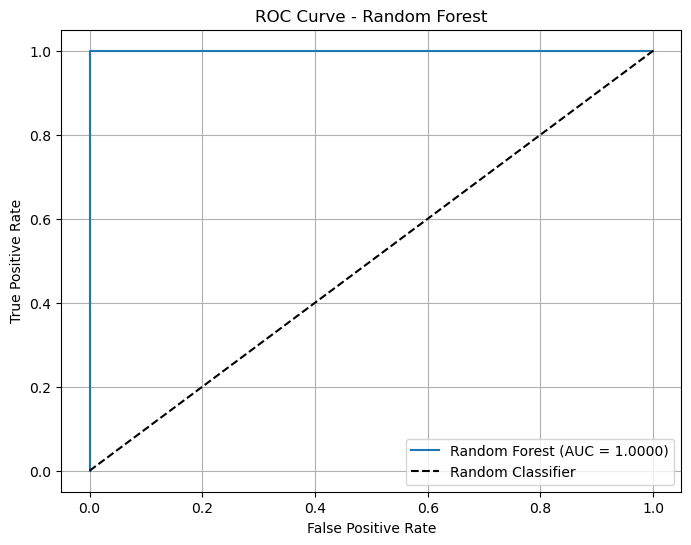

In [10]:
print(f"\n📈 Detailed Evaluation: {selected_model_name}")
print("=" * 80)

if selected_model_name == 'Logistic Regression':
    best_pred = lr_pred
    best_pred_proba = lr_pred_proba
elif selected_model_name == 'Random Forest':
    best_pred = rf_pred
    best_pred_proba = rf_pred_proba
else:
    best_pred = xgb_pred
    best_pred_proba = xgb_pred_proba

# Classification Report
print("\n📋 Classification Report:")
print(classification_report(y_test, best_pred, target_names=['Active', 'Churned']))

# Confusion Matrix
print("\n📊 Confusion Matrix:")
cm = confusion_matrix(y_test, best_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Active', 'Churned'], 
            yticklabels=['Active', 'Churned'])
plt.title(f'Confusion Matrix - {selected_model_name}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, best_pred_proba)
auc_score = roc_auc_score(y_test, best_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'{selected_model_name} (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {selected_model_name}')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Create models directory if it doesn't exist
models_dir = '../ml_models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"📁 Created directory: {models_dir}")

# Save model, scaler, and encoder
model_path = os.path.join(models_dir, 'customer_churn_model.pkl')
scaler_path = os.path.join(models_dir, 'churn_scaler.pkl')
encoder_path = os.path.join(models_dir, 'churn_label_encoder.pkl')

joblib.dump(selected_model, model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(label_encoder, encoder_path)

print(f"✅ Model saved: {model_path}")
print(f"✅ Scaler saved: {scaler_path}")
print(f"✅ Label encoder saved: {encoder_path}")

# Save feature names for reference
feature_names_path = os.path.join(models_dir, 'churn_feature_names.pkl')
joblib.dump(list(X.columns), feature_names_path)
print(f"✅ Feature names saved: {feature_names_path}")


✅ Model saved: ../ml_models\customer_churn_model.pkl
✅ Scaler saved: ../ml_models\churn_scaler.pkl
✅ Label encoder saved: ../ml_models\churn_label_encoder.pkl
✅ Feature names saved: ../ml_models\churn_feature_names.pkl


## 12. Prediction Function


In [12]:
def predict_churn(customer_data, model, scaler, label_encoder, feature_names):
    """
    Predict churn risk for a customer.
    
    Parameters:
    -----------
    customer_data : dict
        Dictionary with customer features:
        {
            'customer_id': str,
            'last_purchase_date': str (YYYY-MM-DD),
            'total_orders': int,
            'avg_gap_days': float,
            'total_spend': float,
            'spend_trend': str ('increasing', 'stable', 'decreasing'),
            'days_since_last_order': int,
            'category_preference': str
        }
    model : trained model
    scaler : fitted StandardScaler
    label_encoder : fitted LabelEncoder
    feature_names : list of feature names in order
    
    Returns:
    --------
    dict : {
        'customerId': str,
        'churnRisk': float (0-1),
        'churnPrediction': int (0 or 1),
        'riskLevel': str ('Low', 'Medium', 'High')
    }
    """
    
    # Create DataFrame from customer data
    customer_df = pd.DataFrame([customer_data])
    
    # Convert dates
    today = datetime.now()
    customer_df['last_purchase_date'] = pd.to_datetime(customer_df['last_purchase_date'])
    
    # Calculate engineered features
    customer_df['recency'] = (today - customer_df['last_purchase_date']).dt.days
    
    # Estimate first purchase date
    customer_df['first_purchase_date'] = customer_df['last_purchase_date'] - pd.to_timedelta(
        customer_df['total_orders'] * customer_df['avg_gap_days'], unit='D'
    )
    
    customer_df['total_days_active'] = (today - customer_df['first_purchase_date']).dt.days
    customer_df['total_days_active'] = customer_df['total_days_active'].clip(lower=1)
    customer_df['frequency'] = customer_df['total_orders'] / customer_df['total_days_active']
    
    customer_df['avg_gap_days'] = customer_df['avg_gap_days'].clip(lower=1)
    
    customer_df['spend_trend_encoded'] = customer_df['spend_trend'].map({
        'increasing': 1,
        'stable': 0,
        'decreasing': -1
    })
    
    customer_df['avg_order_value'] = customer_df['total_spend'] / customer_df['total_orders'].clip(lower=1)
    customer_df['purchase_velocity'] = (customer_df['total_orders'] / customer_df['total_days_active']) * 30
    customer_df['recency_ratio'] = customer_df['recency'] / customer_df['avg_gap_days'].clip(lower=1)
    
    # Prepare feature matrix
    feature_columns = [
        'recency',
        'frequency',
        'avg_gap_days',
        'total_spend',
        'spend_trend_encoded',
        'days_since_last_order',
        'avg_order_value',
        'purchase_velocity',
        'recency_ratio'
    ]
    
    X_numeric = customer_df[feature_columns].copy()
    
    # Encode category
    try:
        category_encoded = label_encoder.transform(customer_df['category_preference'])
    except ValueError:
        # If category not seen in training, use most common category
        category_encoded = [label_encoder.transform([label_encoder.classes_[0]])[0]]
    
    X_categorical_encoded = pd.DataFrame(
        category_encoded,
        columns=['category_preference_encoded'],
        index=X_numeric.index
    )
    
    # Combine features
    X = pd.concat([X_numeric, X_categorical_encoded], axis=1)
    
    # Ensure feature order matches training
    X = X[feature_names]
    
    # Scale features
    X_scaled = scaler.transform(X)
    
    # Predict
    churn_probability = model.predict_proba(X_scaled)[0, 1]
    churn_prediction = model.predict(X_scaled)[0]
    
    # Determine risk level
    if churn_probability < 0.3:
        risk_level = 'Low'
    elif churn_probability < 0.7:
        risk_level = 'Medium'
    else:
        risk_level = 'High'
    
    return {
        'customerId': customer_data['customer_id'],
        'churnRisk': float(churn_probability),
        'churnPrediction': int(churn_prediction),
        'riskLevel': risk_level
    }

print("✅ Prediction function created")


✅ Prediction function created


In [13]:
print("\n🎯 Demo: Predicting Churn Risk for Sample Customers")
print("=" * 80)

# Load feature names
feature_names = list(X.columns)

# Sample customers
sample_customers = [
    {
        'customer_id': 'USER_0001',
        'last_purchase_date': (datetime.now() - timedelta(days=5)).strftime('%Y-%m-%d'),
        'total_orders': 25,
        'avg_gap_days': 7.5,
        'total_spend': 45000.0,
        'spend_trend': 'increasing',
        'days_since_last_order': 5,
        'category_preference': 'Vegetables'
    },
    {
        'customer_id': 'USER_0002',
        'last_purchase_date': (datetime.now() - timedelta(days=60)).strftime('%Y-%m-%d'),
        'total_orders': 8,
        'avg_gap_days': 12.0,
        'total_spend': 12000.0,
        'spend_trend': 'decreasing',
        'days_since_last_order': 60,
        'category_preference': 'Fruits'
    },
    {
        'customer_id': 'USER_0003',
        'last_purchase_date': (datetime.now() - timedelta(days=120)).strftime('%Y-%m-%d'),
        'total_orders': 5,
        'avg_gap_days': 20.0,
        'total_spend': 8000.0,
        'spend_trend': 'decreasing',
        'days_since_last_order': 120,
        'category_preference': 'Grains'
    },
    {
        'customer_id': 'USER_0004',
        'last_purchase_date': (datetime.now() - timedelta(days=2)).strftime('%Y-%m-%d'),
        'total_orders': 40,
        'avg_gap_days': 5.0,
        'total_spend': 55000.0,
        'spend_trend': 'increasing',
        'days_since_last_order': 2,
        'category_preference': 'Dairy'
    },
    {
        'customer_id': 'USER_0005',
        'last_purchase_date': (datetime.now() - timedelta(days=90)).strftime('%Y-%m-%d'),
        'total_orders': 3,
        'avg_gap_days': 30.0,
        'total_spend': 5000.0,
        'spend_trend': 'stable',
        'days_since_last_order': 90,
        'category_preference': 'Spices'
    }
]

predictions = []
for customer in sample_customers:
    result = predict_churn(customer, selected_model, scaler, label_encoder, feature_names)
    predictions.append(result)
    print(f"\n📊 Customer: {result['customerId']}")
    print(f"   Churn Risk: {result['churnRisk']:.4f} ({result['riskLevel']})")
    print(f"   Prediction: {'🚨 Churned' if result['churnPrediction'] == 1 else '✅ Active'}")

print("\n" + "=" * 80)
print("✅ Demo complete!")



🎯 Demo: Predicting Churn Risk for Sample Customers

📊 Customer: USER_0001
   Churn Risk: 0.0000 (Low)
   Prediction: ✅ Active

📊 Customer: USER_0002
   Churn Risk: 1.0000 (High)
   Prediction: 🚨 Churned

📊 Customer: USER_0003
   Churn Risk: 1.0000 (High)
   Prediction: 🚨 Churned

📊 Customer: USER_0004
   Churn Risk: 0.0000 (Low)
   Prediction: ✅ Active

📊 Customer: USER_0005
   Churn Risk: 1.0000 (High)
   Prediction: 🚨 Churned

✅ Demo complete!


## 14. Top N High-Risk Customers


In [14]:
print("\n🚨 Identifying Top High-Risk Customers for Re-engagement")
print("=" * 80)

# Predict churn risk for all test set customers
test_predictions = selected_model.predict_proba(X_test_scaled)[:, 1]

# Create DataFrame with customer IDs and predictions
# (In real scenario, you'd have actual customer IDs from test set)
test_customer_ids = [f'TEST_USER_{i}' for i in range(len(X_test))]

risk_df = pd.DataFrame({
    'customer_id': test_customer_ids,
    'churn_risk': test_predictions
})

# Sort by churn risk (highest first)
risk_df = risk_df.sort_values('churn_risk', ascending=False)

# Get top N high-risk customers
N = 20
top_risk_customers = risk_df.head(N)

print(f"\n📊 Top {N} High-Risk Customers:")
print(top_risk_customers.to_string(index=False))

print(f"\n✅ Identified {N} customers for re-engagement campaigns")



🚨 Identifying Top High-Risk Customers for Re-engagement

📊 Top 20 High-Risk Customers:
  customer_id  churn_risk
TEST_USER_239         1.0
TEST_USER_124         1.0
TEST_USER_566         1.0
TEST_USER_599         1.0
TEST_USER_267         1.0
TEST_USER_127         1.0
TEST_USER_242         1.0
TEST_USER_198         1.0
TEST_USER_130         1.0
TEST_USER_268         1.0
TEST_USER_132         1.0
TEST_USER_200         1.0
 TEST_USER_12         1.0
 TEST_USER_13         1.0
TEST_USER_134         1.0
 TEST_USER_15         1.0
 TEST_USER_16         1.0
TEST_USER_567         1.0
TEST_USER_573         1.0
 TEST_USER_19         1.0

✅ Identified 20 customers for re-engagement campaigns


## 15. Feature Importance (for Random Forest or XGBoost)



📊 Feature Importance Analysis: Random Forest

                    feature  importance
                    recency    0.430717
      days_since_last_order    0.324142
                total_spend    0.106908
              recency_ratio    0.067735
            avg_order_value    0.035127
        spend_trend_encoded    0.023972
          purchase_velocity    0.005830
               avg_gap_days    0.002989
                  frequency    0.002579
category_preference_encoded    0.000000


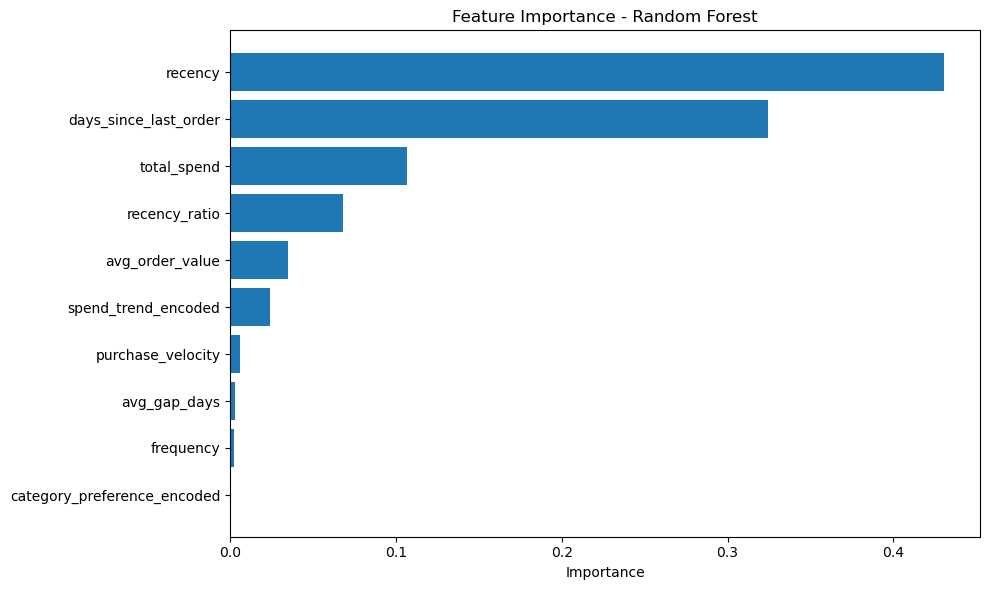

In [15]:
if selected_model_name in ['Random Forest', 'XGBoost']:
    print(f"\n📊 Feature Importance Analysis: {selected_model_name}")
    print("=" * 80)
    
    if selected_model_name == 'Random Forest':
        feature_importance = rf_model.feature_importances_
    else:
        feature_importance = xgb_model.feature_importances_
    
    # Create DataFrame
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)
    
    print("\n" + importance_df.to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance_df)), importance_df['importance'])
    plt.yticks(range(len(importance_df)), importance_df['feature'])
    plt.xlabel('Importance')
    plt.title(f'Feature Importance - {selected_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️  Feature importance not available for Logistic Regression")
    print("    (Use Random Forest or XGBoost for feature importance analysis)")


## 16. Model Validation Summary


In [16]:
# Restore results if needed
if 'model_results' in locals():
    results = model_results.copy()

print("\n📋 Final Model Validation Summary")
print("=" * 80)
print(f"\n🏆 Selected Model: {selected_model_name}")
print(f"\n📊 Performance Metrics:")
print(f"   Accuracy:  {results[selected_model_name]['accuracy']:.4f}")
print(f"   Precision: {results[selected_model_name]['precision']:.4f}")
print(f"   Recall:    {results[selected_model_name]['recall']:.4f}")
print(f"   F1-Score:  {results[selected_model_name]['f1']:.4f}")
print(f"   AUC-ROC:   {results[selected_model_name]['auc']:.4f}")

print(f"\n✅ Model artifacts saved successfully!")
print(f"   Model: customer_churn_model.pkl")
print(f"   Scaler: churn_scaler.pkl")
print(f"   Encoder: churn_label_encoder.pkl")

print(f"\n🚀 Model is ready for deployment!")



📋 Final Model Validation Summary

🏆 Selected Model: Random Forest

📊 Performance Metrics:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000
   AUC-ROC:   1.0000

✅ Model artifacts saved successfully!
   Model: customer_churn_model.pkl
   Scaler: churn_scaler.pkl
   Encoder: churn_label_encoder.pkl

🚀 Model is ready for deployment!


## 17. Optional: SHAP Explanations (Install Required)

```bash
pip install shap
```


In [17]:
# Uncomment to use SHAP for model explainability
# import shap
# 
# if selected_model_name in ['Random Forest', 'XGBoost']:
#     print("\n🔍 Generating SHAP explanations...")
#     
#     # Create SHAP explainer
#     explainer = shap.TreeExplainer(selected_model)
#     shap_values = explainer.shap_values(X_test_scaled[:100])  # Sample of 100
#     
#     # Plot SHAP summary
#     shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=feature_names, show=False)
#     plt.show()
# else:
#     print("\n⚠️  SHAP not available for Logistic Regression")
#     print("    Use Random Forest or XGBoost for SHAP explanations")
